<a href="https://colab.research.google.com/github/Vakhranev/Heritage/blob/main/t-score%20%2B%20%D1%81%D1%82%D1%83%D0%B4%D0%B5%D0%BD%D1%82%D1%8B%3A%20%D1%8F%D1%89%D0%B8%D0%BA%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

# Загрузка данных из CSV файла
df = pd.read_csv('sorted_bigrams_unique_t_score.csv')

# Удаление повторяющихся строк
df.drop_duplicates(inplace=True)

# Сохранение изменений в файле
df.to_csv('sorted_bigrams_unique_t_score.csv', index=False)

In [2]:
import json
import pandas as pd
from tqdm import tqdm

# Загрузка данных из файла с частотами униграмм
with open('cococo_unigram_freq_fixed.json', 'r', encoding='utf-8') as file:
    unigrams_dict = json.load(file)

# Загрузка данных из CSV файла
df = pd.read_csv('sorted_bigrams_unique_t_score.csv')

# Преобразование данных в словарь
bigrams_dict = dict(zip(df['Bigram'], df['T_Score']))

# Функция для пересчёта t-score
def calc_t_score(bigrams_dict, unigrams_dict):
    N = sum(bigrams_dict.values())
    bigram_t = {}
    max_tscore = 0
    p_bar = tqdm(desc="calculate t-score", total=len(bigrams_dict))
    for bigram, count in bigrams_dict.items():
        w1, w2 = bigram.split()
        unigram_freq_w1 = unigrams_dict.get(w1, 0)
        unigram_freq_w2 = unigrams_dict.get(w2, 0)
        if count == 0 or unigram_freq_w1 == 0 or unigram_freq_w2 == 0:
            # Пропускаем биграммы с нулевым количеством или нулевой частотой униграмм
            continue
        E_xy = (unigram_freq_w1 + unigram_freq_w2) / N
        t_score = abs((count - E_xy) / (count ** 0.5)) # Берем абсолютное значение разницы
        bigram_t[bigram] = t_score
        if t_score > max_tscore:
            max_tscore = t_score
        p_bar.update()
    bigram_t = {bigram: bigram_t[bigram] / max_tscore for bigram in sorted(bigram_t, key=bigram_t.get, reverse=True)} # sort and normalize
    return bigram_t

# Применение функции к данным
result = calc_t_score(bigrams_dict, unigrams_dict)

# Преобразование результата в DataFrame
result_df = pd.DataFrame({'Bigram': list(result.keys()), 'T_Score': list(result.values())})

# Сохранение результата в файл
result_df.to_csv('sorted_bigrams_unique_t_score_normalized.csv', index=False)

calculate t-score:  88%|████████▊ | 3651/4160 [00:00<00:00, 189045.03it/s]


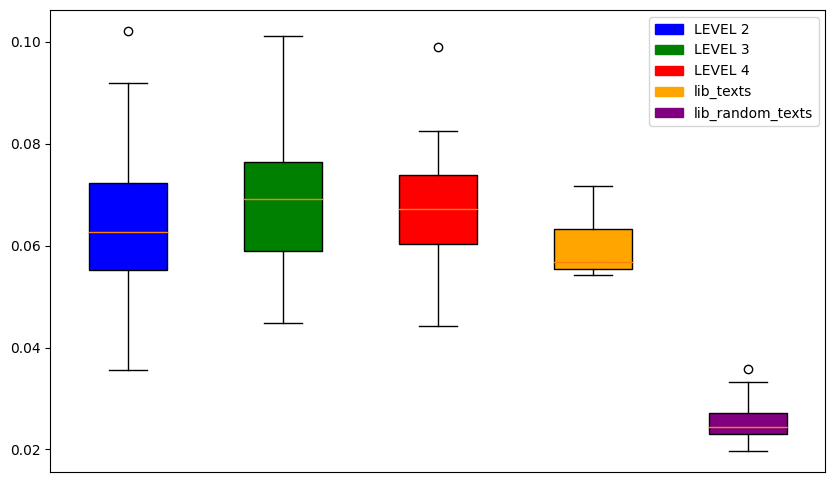

In [4]:
import json
import matplotlib.pyplot as plt

# Чтение файла america_texts.json
mmr_data = {}
with open('america_texts.json', 'r') as file:
    mrr_texts_data = json.load(file)
    for text_name, text_info in mrr_texts_data.items():
        mmr_rank_unique = text_info.get('mmr_t_score_unique', 0)
        mmr_data[text_name] = mmr_rank_unique

# Чтение файла files_by_levels.txt
files_by_levels = {'LEVEL 2': [], 'LEVEL 3': [], 'LEVEL 4': []}
with open('files_by_levels.txt', 'r') as file:
    current_level = None
    for line in file:
        line = line.strip()
        if line.startswith('LEVEL'):
            current_level = line
        elif line:
            files_by_levels[current_level].append(line)

# Чтение файла lib_texts.json
lib_texts = {}
with open('lib_texts.json', 'r') as file:
    lib_texts_data = json.load(file)
    for text_name, text_info in lib_texts_data.items():
        mmr_rank_unique = text_info.get('mmr_t_score_unique', 0)
        lib_texts[text_name] = mmr_rank_unique

# Чтение файла lib_random_texts.json
lib_random_texts = {}
with open('lib_random_texts.json', 'r') as file:
    lib_random_texts_data = json.load(file)
    for text_name, text_info in lib_random_texts_data.items():
        temporal_text_name = text_name + "_"
        for text_type, text_other in text_info.items():
            if text_type == 'random_texts':
                for text_number, text_else in text_other.items():
                    temporal_text_name += text_number
                    mmr_rank_unique = text_else.get('mmr_t_score_unique')
                    lib_random_texts[temporal_text_name] = mmr_rank_unique
                    temporal_text_name = text_name + "_"

# Теперь у нас есть данные из всех файлов. Мы можем начать построение диаграммы.

# Получение уровней и их соответствующих цветов
levels_colors = {'LEVEL 2': 'blue', 'LEVEL 3': 'green', 'LEVEL 4': 'red', 'lib_texts': 'orange', 'lib_random_texts': 'purple'}

# Построение диаграммы
plt.figure(figsize=(10, 6))

# Сбор данных для ящиков с усами из files_by_levels
data_to_plot = []
labels_to_plot = []
for level, files in files_by_levels.items():
    data_to_plot.append([mmr_data[file] for file in files])
    labels_to_plot.append(level)

# Сбор данных для ящиков с усами из lib_texts
data_to_plot.append(list(lib_texts.values()))
labels_to_plot.append('lib_texts')

# Сбор данных для ящиков с усами из lib_random_texts
data_to_plot.append(list(lib_random_texts.values()))
labels_to_plot.append('lib_random_texts')

# Построение ящиков с усами
bp = plt.boxplot(data_to_plot, patch_artist=True)

# Цвет каждого ящика
colors = [levels_colors[level] for level in labels_to_plot]

# Задаем цвета ящиков
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Добавление легенды
legend_handles = [plt.Rectangle((0,0),1,1, color=levels_colors[label]) for label in labels_to_plot]
plt.legend(legend_handles, labels_to_plot)

# Удаление подписей с оси x
plt.xticks([])

# Показать диаграмму
plt.show()

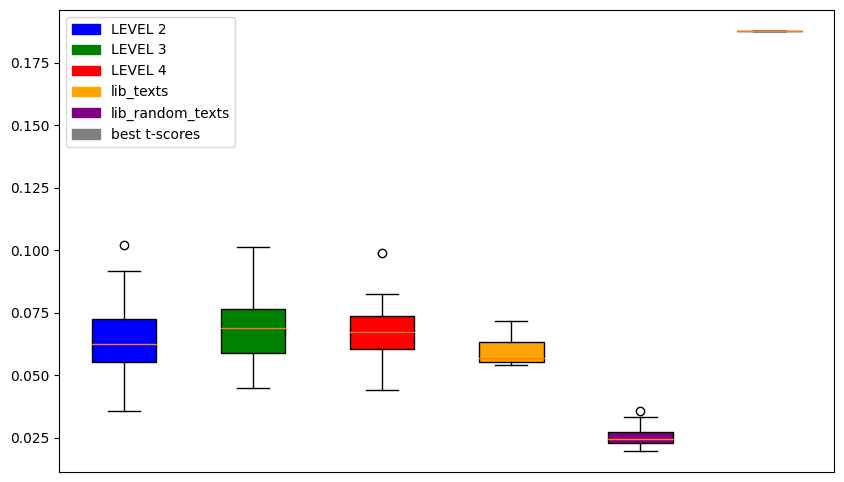

In [6]:
# Добавление цвета для метки 'best t-scores'
levels_colors['best t-scores'] = 'gray'

# Построение ящиков с усами
plt.figure(figsize=(10, 6))
bp = plt.boxplot(data_to_plot, patch_artist=True)

# Цвет каждого ящика
colors = [levels_colors[level] for level in labels_to_plot]

# Задаем цвета ящиков
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Добавление легенды
legend_handles = [plt.Rectangle((0,0),1,1, color=levels_colors[label]) for label in labels_to_plot]
plt.legend(legend_handles, labels_to_plot)

# Удаление подписей с оси x
plt.xticks([])

# Показать диаграмму
plt.show()